## Introduction:

<a href = 'https://www.mercari.com/'>Mercari </a>, Japan’s biggest community-powered shopping app, knows one problem deeply. They’d like to offer pricing suggestions to sellers, but this is tough because their sellers are enabled to put just about anything, or any bundle of things, on Mercari’s marketplace.

Dataset : https://www.kaggle.com/thykhuely/data

We are provided of the following information:
- train_id — the id of the listing
- name — the title of the listing
- item_condition_id — the condition of the items provided by the sellers
- category_name — category of the listing
- brand_name — the name of the brand
- price — the price that the item was sold for. This is target variable that we will predict
- shipping — 1 if shipping fee is paid by seller and 0 by buyer
- item_description — the full description of the item



## Objective:
<b>To build a machine learning model to recommends the right product prices to Mercari's seller.</b>

## Exploratory Data Analysis:
Exploratory Data Analysis (EDA) is an approach/philosophy for data analysis that employs a variety of techniques (mostly graphical) to:
- maximize insight into a data set;
- uncover underlying structure;
- extract important variables;
- detect outliers and anomalies;
- test underlying assumptions;
- develop parsimonious models; and
- determine optimal factor settings.


For the given data besides the unique identifier (item_id), there are 7 variables in the dataset . We will sequentially go through each of them with a brief statistical summary.

- 1. <b>Numerical/Continuous Features</b>
    - price: the item's final bidding price. This will be our reponse / independent variable that we need to predict in the test set
    
- 2.<b>Categorical Features:</b>
    - shipping cost: A binary indicator, 1 if shipping fee is paid by seller and 0 if it's paid by buyer
    - item_condition_id: The condition of the items provided by the seller
    - name: The item's name
    - brand_name: The item's producer brand name
    - category_name: The item's single or multiple categories that are separated by "\"
    - item_description: A short description on the item that may include removed words, flagged by [rm]


## Imports 

In [1]:
# for data manipulations
import pandas as pd
import numpy as np

# for dealing with string
import re
import string
import nltk


# for plotting 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style= 'white')

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls
%matplotlib inline
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.transform import  factor_cmap
from bokeh.plotting import figure, show, output_notebook

# for textminig 
from nltk.stem.porter import  *
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction import stop_words

from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# for handling warning
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('lda').setLevel(logging.WARNING)


Loading large datasets with pandas:
https://www.dataquest.io/blog/pandas-big-data/

Also, link:https://csvkit.readthedocs.io/en/1.0.2/ for merging multiple datasets together.

In [2]:
# loading the datasets
# Note - need to specify the separations as tabular seperation
train = pd.read_csv('./data/train.tsv', sep='\t')
test = pd.read_csv('./data/test.tsv', sep='\t')
# size of training and test datasets
print(train.shape)
print(test.shape)

(1482535, 8)
(693359, 7)


In [3]:
# look at the different datatype in the dataset:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [4]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Target Variable: Price

The next standard check is with our response or target variables, which in this case is the price we are suggesting to the Mercari's marketplace sellers. The median price of all the items in the training is about \$26.7 but given the existence of some extreme values of over \$100 and the maximum at \$2,009.0 the distribution of the variables is heavily skewed to the left. So let's make log-transformation on the price (we added +1 to the value before the transformation to avoid zero and negative values).

In [5]:
# lets look at the stats for the target variable 
train.price.describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

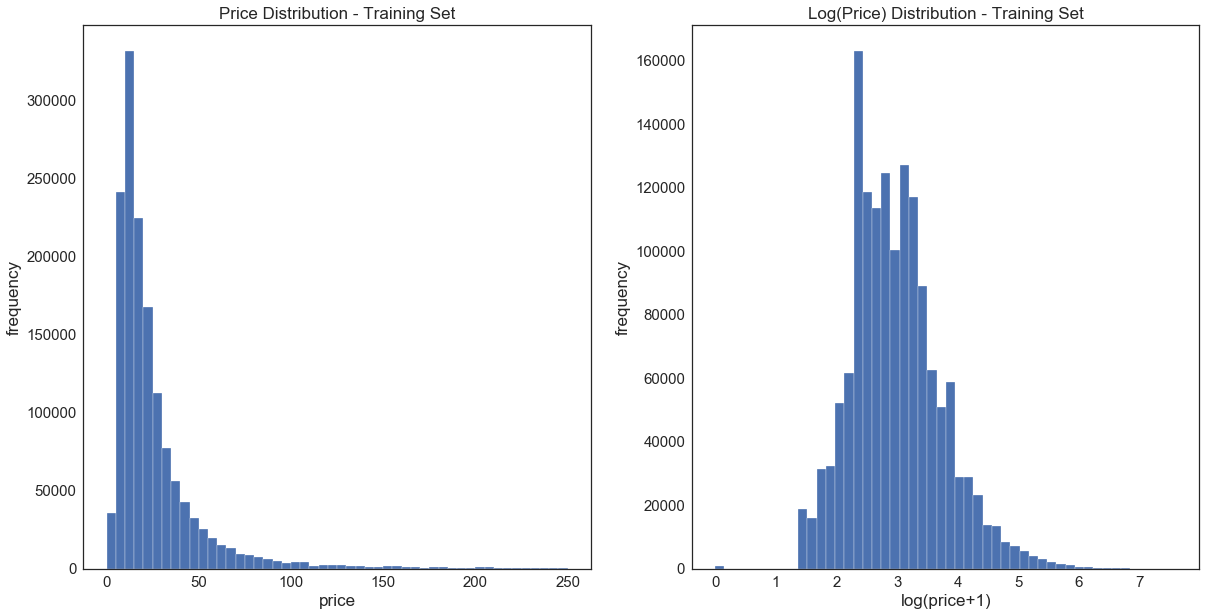

In [6]:
# plot for checking the price distribution
plt.subplot(1,2,1) # 1row, 2columns, 1st fig
(train['price']).plot.hist(bins=50, figsize=(20,10), edgecolor='white',range=[0,250])
plt.xlabel('price', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Price Distribution - Training Set', fontsize=17)

plt.subplot(1, 2, 2)
np.log(train['price']+1).plot.hist(bins=50, figsize=(20,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.tick_params(labelsize=15)
plt.title('Log(Price) Distribution - Training Set', fontsize=17)
plt.show()

## Shipping:
The shipping cost burden is decently splitted between sellers and buyers with more than half of the items' shipping fees are paid by the sellers (55%). In addition, the average price paid by users who have to pay for shipping fees is lower than those that don't require additional shipping cost. This matches with our perception that the sellers need a lower price to compensate for the additional shipping.

In [7]:
# the percent of shipping paid by seller vs buyer
train.shipping.value_counts()/len(train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

In [8]:
prc_shipBySeller = train.loc[train.shipping==1, 'price']
prc_shipByBuyer = train.loc[train.shipping==0, 'price']

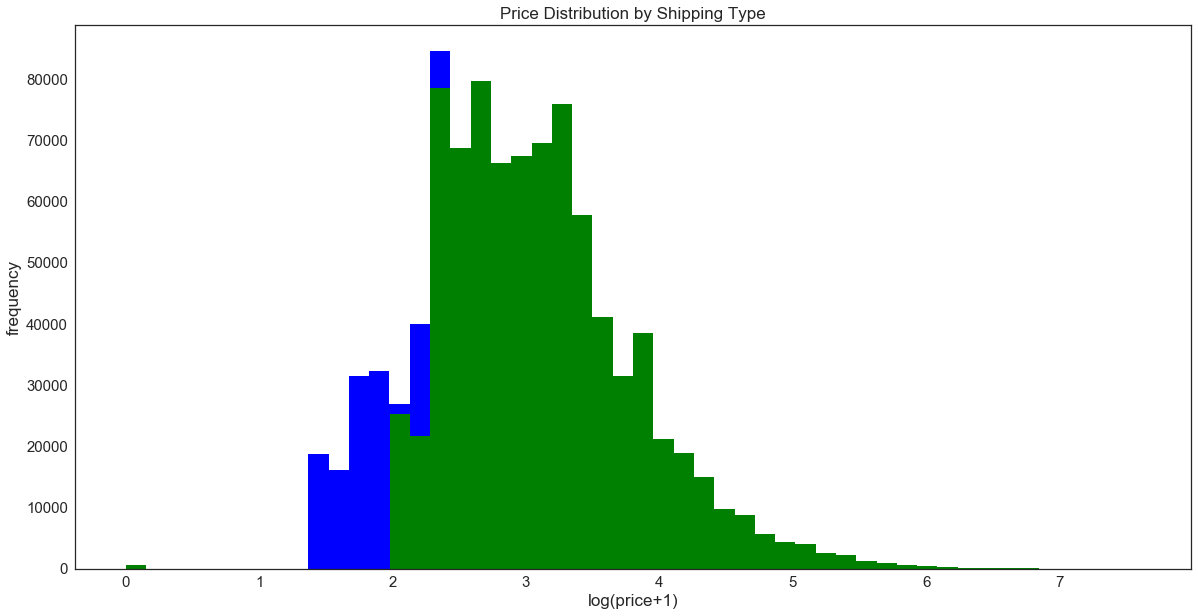

In [9]:
fig, ax = plt.subplots(figsize =(20,10))
ax.hist(np.log(prc_shipBySeller+1), color = 'blue', bins = 50,
       label= 'Price when seller pays shipping')

ax.hist(np.log(prc_shipByBuyer+1), color = 'green',bins = 50,
       label = 'Price when buyer pays shipping')

ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('log(price+1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.tick_params(labelsize=15)
plt.show()


## Item Category

There are about 1,287 unique categories but among each of them, we will always see a main/general category firstly, followed by two more particular subcategories (e.g. Beauty/Makeup/Face or Lips). In adidition, there are about 6,327 items that do not have a category labels. Let's split the categories into three different columns. We will see later that this information is actually quite important from the seller's point of view and how we handle the missing information in the brand_name column will impact the model's prediction.

In [10]:
# check for unique item categories
print("There are %d unique values in the category column." % train['category_name'].nunique())

There are 1287 unique values in the category column.


In [11]:
# lets see the top 10 categories
train.category_name.value_counts().head(10)

Women/Athletic Apparel/Pants, Tights, Leggings                 60177
Women/Tops & Blouses/T-Shirts                                  46380
Beauty/Makeup/Face                                             34335
Beauty/Makeup/Lips                                             29910
Electronics/Video Games & Consoles/Games                       26557
Beauty/Makeup/Eyes                                             25215
Electronics/Cell Phones & Accessories/Cases, Covers & Skins    24676
Women/Underwear/Bras                                           21274
Women/Tops & Blouses/Blouse                                    20284
Women/Tops & Blouses/Tank, Cami                                20284
Name: category_name, dtype: int64

In [12]:
# check the number of obs with missing categories
print("There are %d items that do not have a label." % train['category_name'].isnull().sum())

There are 6327 items that do not have a label.


In [13]:
# lets split the categories in General/subcat-1/subcat-2

def split_cat(text):
    try: return text.split('/')
    except: return ('No Label', 'No Label', 'No Label')

train['general_cat'], train['subcat_1'], train['subcat_2']= zip(*train.category_name.apply(
lambda x: split_cat(x)))
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces


In [14]:
# lets check the number of general , subcat_1 and subcat_2
print('There are %d unique general categories.' % train['general_cat'].nunique())
print("There are %d unique first sub-categories." % train['subcat_1'].nunique())

print("There are %d unique second sub-categories." % train['subcat_2'].nunique())


There are 11 unique general categories.
There are 114 unique first sub-categories.
There are 871 unique second sub-categories.


Overall, we have 11 main categories
- Women                     664385
- Beauty                    207828
- Kids                      171689
- Electronics               122690
- Men                        93680
- Home                       67871
- Vintage & Collectibles     46530
- Other                      45351
- Handmade                   30842
- Sports & Outdoors          25342
- No Label                    6327

(114 in the first sub-categories and 871 second sub-categories): women's and beauty items as the two most popular categories (more than 50% of the observations), followed by kids and electronics

In [5]:
# plot for the General category distribution

#fetching the values from value i.e the category name
x = train['general_cat'].value_counts().index.values.astype('str')

# fetching the count
y = train['general_cat'].value_counts().values

pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

# Bar plot in plotly
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Main Category',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Category'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [1]:
# plot for the subcategory-1 distribution

#fetching the values from value i.e the category name
x = train['subcat_1'].value_counts().head(15).index.values.astype('str')

# fetching the count
y = train['subcat_1'].value_counts().head(15).values

pct = [("%.2f"%(v*100))+"%"for v in (y/len(train))]

# Bar plot in plotly
trace1 = go.Bar(x=x, y=y, text=pct,
                marker=dict(
                color = y,colorscale='Portland',showscale=True,
                reversescale = False
                ))
layout = dict(title= 'Number of Items by Sub Category (Top 15)',
              yaxis = dict(title='Count'),
              xaxis = dict(title='SubCategory'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

In [6]:
# plot for price distribution by category

# extracting the price for different categories
general_cats = train['general_cat'].unique()
x = [train.loc[train['general_cat']==cat, 'price'] for cat in general_cats]

#performing log transformation on the price
data = [go.Box(x=np.log(x[i]+1), name=general_cats[i]) for i in range(len(general_cats))]

layout = dict(title="Price Distribution by General Category",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)



From the pricing (log of price) point of view, all the categories are pretty well distributed, with no category with an extraordinary pricing point

## Brand Name 

In [18]:
print("There are %d unique brand names in the training dataset." % train['brand_name'].nunique())

There are 4809 unique brand names in the training dataset.


In [19]:
# plotting the top-10 brands 
x = train['brand_name'].value_counts().index.values.astype('str')[:10]
y = train['brand_name'].value_counts().values[:10]

In [20]:
# trace1 = go.Bar(x=x, y=y, 
#                 marker=dict(
#                 color = y,colorscale='Portland',showscale=True,
#                 reversescale = False
#                 ))
# layout = dict(title= 'Top 10 Brand by Number of Items',
#               yaxis = dict(title='Brand Name'),
#               xaxis = dict(title='Count'))
# fig=dict(data=[trace1], layout=layout)
# py.iplot(fig)


In [2]:
 
# extracting the price for different brands
brands = train['brand_name'].value_counts().index.values.astype('str')[:10]
x = [train.loc[train['brand_name']==brand, 'price'] for brand in brands]

#performing log transformation on the price
data = [go.Box(x=np.log(x[i]+1), name=brands[i]) for i in range(len(brands))]

layout = dict(title="Price Distribution by Brands",
              yaxis = dict(title='Frequency'),
              xaxis = dict(title='Category'))
fig = dict(data=data, layout=layout)
py.iplot(fig)

# Item Description

It will be more challenging to parse through this particular item since it's unstructured data. Does it mean a more detailed and lengthy description will result in a higher bidding price? We will strip out all punctuations, remove some english stop words (i.e. redundant words such as "a", "the", etc.) and any other words with a length less than 3:

In [22]:
def wordCount(text):
    # convert to lower case and strip regex
    try:
        # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return len(words)
    except: 
        return 0

In [23]:
# add a column of word counts to both the training and test set
train['desc_len'] = train['item_description'].apply(lambda x: wordCount(x))
test['desc_len'] = test['item_description'].apply(lambda x: wordCount(x))

In [24]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2,desc_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,Men,Tops,T-shirts,1
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,Electronics,Computers & Tablets,Components & Parts,14
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,Women,Tops & Blouses,Blouse,8
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,Home,Home Décor,Home Décor Accents,14
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,Women,Jewelry,Necklaces,3


In [3]:
# plotting the relation of price and Description length

df = train.groupby('desc_len')['price'].mean().reset_index()

# scatter plot with lines 
trace1 = go.Scatter(
x = df['desc_len'],
y = np.log(df['price']+ 1),
mode = 'lines+markers',
name = 'lines+markers'
)

layout = dict(title= 'Average log(Price) by Description Length',
             yaxis = dict(title= 'Average Log(Price)'),
             xaxis= dict(title= 'Desctiption Length'))

fig = dict(data = [trace1], layout = layout)
py.iplot(fig)

We also need to check if there are any missing values in the item description (4 observations don't have a description) and we wil l remove those observations from our training set.

In [26]:
train.item_description.isnull().sum()

4

In [27]:
# only keeping the observations with descriptions
train = train[pd.notnull(train.item_description)]

In [28]:
# Creating a dictionay of words in each category
def tokenize(text):
    # convert to lower case and strip regex
    try:
        # convert to lower case and strip regex
        text = text.lower()
        regex = re.compile('[' + re.escape(string.punctuation) + '0-9\\r\\t\\n]')
        txt = regex.sub(" ", text)
        # tokenize
        # words = nltk.word_tokenize(clean_txt)
        # remove stop words
        words = [w for w in txt.split(" ") \
                 if not w in stop_words.ENGLISH_STOP_WORDS and len(w)>3]
        return words
    
    except:
        return 0

cat_desc = dict()
for cat in general_cats:
    text = " ".join(train.loc[train['general_cat'] == cat, 'item_description'].values)
    cat_desc[cat] = tokenize(text)

# flat list of all words combined
flat_lst = [item for sublist in list(cat_desc.values()) for item in sublist]
allWordsCount = Counter(flat_lst)

all_top10 = allWordsCount.most_common(20)
x = [w[0] for w in all_top10]
y = [w[1] for w in all_top10]

In [4]:
trace1 = go.Bar(x=x, y=y, text=pct)
layout = dict(title= 'Word Frequency',
              yaxis = dict(title='Count'),
              xaxis = dict(title='Word'))
fig=dict(data=[trace1], layout=layout)
py.iplot(fig)

If we look at the most common words by category, we  see that, size, brand, free and shipping, condition is very commonly used by the sellers, probably with the intention to familiarize the customers with the product.
<b>Brand names</b> also played quite an important role - it's one of the most popular in all four categories.

In [33]:
train.to_pickle('./pickle/train.pkl')
test.to_pickle('./pickle/test.pkl')